# Compute Antarctic, depth integrated, cross slope heat transport, online terms

We have

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean
import os

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35233/status,
Dashboard: /proxy/35233/status,Workers: 28
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43097,Workers: 28
Dashboard: /proxy/35233/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:37267,Total threads: 1
Dashboard: /proxy/44245/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:39657,


## Importing slope vars for transposition


In [3]:
Slopedata=xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/slope1000m.nc') #obtained through calc_u_on_depth_contour

## Getting the Heat Transport along isobath

In [4]:
session = cc.database.create_session()

In [5]:
year = '2080'
exp = '01deg_jra55v13_ryf9091'
#exp = '01deg_jra55v140_iaf'
#exp = '01deg_jra55v13_ryf9091_tides_fixed'

########################################################################################
#Setting the number of days in each month, so I can have the full date fo each month
#             J,  F,  M,  A,  M,  J,  J,  A,  S,  O,  N,  D]
monthdays = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
########################################################################################

start_time='2095-01'
end_time='2095-02'

#FOr importing the daily transports
start_time0='2095-01-01' 
end_time0='2095-01-' + str(monthdays[1-1])
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))
#########################################################################################
# reference density value:
rho_0 = 1035.0
# specific heat capacity of sea water:
cp = 3992.1
lat_range = slice(-90,-59)

isobath_depth = 1000

# pick a freezing point temp:
temp_freezing = -3.82
end_time0

'2095-01-31'

## Open contour data, extract lat/lon on contour

In [6]:
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']

yt_ocean = cc.querying.getvar(exp,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(exp,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(exp,'xt_ocean',session,n=1)
xu_ocean = cc.querying.getvar(exp,'xu_ocean',session,n=1)

In [7]:
# convert isobath masks to data arrays, so we can multiply them later:
#mask_x_transport =xr.DataArray(data['mask_x_transport']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xu_ocean)}).rename(dim_0="yu_ocean",dim_1="xt_ocean")


mask_x_transport =xr.DataArray(data['mask_x_transport']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xu_ocean)}).rename(dim_0="yt_ocean",dim_1="xu_ocean")
mask_y_transport =xr.DataArray(data['mask_y_transport']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xu_ocean)}).rename(dim_0="yu_ocean",dim_1="xt_ocean")
mask_x_transport_numbered =xr.DataArray(data['mask_x_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xt_ocean)}).rename(dim_0="yt_ocean",dim_1="xt_ocean")
mask_y_transport_numbered =xr.DataArray(data['mask_y_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xt_ocean)}).rename(dim_0="yt_ocean",dim_1="xt_ocean")




# mask_x_transport = xr.DataArray(mask_x_transport, coords = [('yt_ocean', yt_ocean), ('xu_ocean', xu_ocean)])
# mask_y_transport = xr.DataArray(mask_y_transport, coords = [('yu_ocean', yu_ocean), ('xt_ocean', xt_ocean)])
# mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
# mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

num_points = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))

In [8]:
lat_along_contour = np.zeros((num_points))
lon_along_contour = np.zeros((num_points))

# locations for zonal transport:
x_indices_masked = mask_x_transport_numbered.stack().values
x_indices = np.sort(x_indices_masked[x_indices_masked>0])
for count in x_indices:
    count = int(count)
    jj = int(np.where(mask_x_transport_numbered==count)[0])
    ii = int(np.where(mask_x_transport_numbered==count)[1])   
    lon_along_contour[count-1] = xu_ocean[ii].values
    lat_along_contour[count-1] = mask_x_transport_numbered.yt_ocean[jj].values
    
# locations for meridional transport:
y_indices_masked = mask_y_transport_numbered.stack().values
y_indices = np.sort(y_indices_masked[y_indices_masked>0])
for count in y_indices:
    count = int(count)
    jj = np.where(mask_y_transport_numbered==count)[0]
    ii = np.where(mask_y_transport_numbered==count)[1]
    lon_along_contour[count-1] = mask_x_transport_numbered.xt_ocean[ii].values
    lat_along_contour[count-1] = yu_ocean[jj].values

In [9]:
Alat_along_contour=lat_along_contour
Alon_along_contour=lon_along_contour

In [10]:
lat_along_contournc=xr.DataArray(lat_along_contour)
lat_along_contournc.to_netcdf('/g/data/x77/wf4500/ASC_project/cross_slope_transport/lat_along_contour.nc')

In [11]:
# contour=[lon_along_contour,lat_along_contour]
# contour2=xr.DataArray(contour)
# contour2.to_netcdf('/g/data/v45/wf4500/lon_lats_1000miso.nc')

## Compute heat transports calculated online

In [12]:
# Note temp_yflux_adv is also positioned on north centre edge of t-cell.
# temp_yflux_adv = cp*rho*dzt*dxt*v*temp

temp_yflux = cc.querying.getvar(exp,'temp_yflux_adv',session,start_time=start_time, end_time=end_time)
temp_xflux = cc.querying.getvar(exp,'temp_xflux_adv',session,start_time=start_time, end_time=end_time)

# select latitude range:
temp_yflux = temp_yflux.sel(yu_ocean=lat_range).sel(time=slice(start_time,end_time)).sel(time=start_time)
temp_xflux = temp_xflux.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time)).sel(time=start_time)

In [13]:
# time average and sum in depth:
# temp_yflux = temp_yflux.mean('time').sum('st_ocean')
# temp_xflux = temp_xflux.mean('time').sum('st_ocean')
temp_yflux = temp_yflux.sum('st_ocean')
temp_xflux = temp_xflux.sum('st_ocean')

temp_yflux = temp_yflux.load()
temp_xflux = temp_xflux.load()

In [14]:
# temp_yflux_year = cc.querying.getvar(exp,'temp_yflux_adv',session,frequency='1 monthly').time
#temp_xflux = cc.querying.getvar(exp,'temp_xflux_adv',session,start_time=start_time, end_time=end_time).sel(time=start_time)
#temp_yflux_year = temp_yflux_year.groupby('time.year').mean(dim='time')
#plt.plot(np.diff(temp_yflux_year.year)) #seems we have this variable every year, from 1950 to 2179
#so it shouldnt be a constraint
#temp_yflux_year.year
temp_xflux

<xarray.DataArray 'temp_xflux_adv' (time: 1, yt_ocean: 510, xu_ocean: 3600)>
array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 1.0342469e+11,  4.2029475e+11,  6.1028283e+11, ...,
         -1.2179240e+12, -9.1440074e+11, -4.1042117e+11],
        [-1.0507209e+10,  3.6890473e+11,  6.8898737e+11, ...,
         -1.1799092e+12, -8.6224706e+11, -4.4117289e+11],
        [-4.0464785e+10,  3.1316381e+11,  6.3197833e+11, ...,
         -9.0978766e+11, -6.7254472e+11, -3.7411009e+11]]], dtype=float32)
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -59.14 -59.08 -59.03
  * time      (time) object 2095-01-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0

In [15]:
vhrho_nt = cc.querying.getvar(exp,'vhrho_nt',session,frequency='1 daily')
#vhrho_nt = vhrho_nt.sel(yt_ocean=lat_range).sel(time=slice(start_time0,end_time0))
#vhrho_nt
test = vhrho_nt.time.groupby('time.year').mean(dim='time')
#ok, it seems like the problem is that we dont have the  2080 year in some of the variables. We need to 
#choose a year of analysis where we have both vhrho_nt and and u,v for analysis, and temp_{x,y}flux

In [16]:
# save a long term average of vhrho_nt and uhrho_et:
outpath = '/g/data/x77/wf4500/ASC_project/uhrho_vhrho_'+start_time+'.nc'
# check if already exists:
if os.path.exists(outpath):
    average_transports = xr.open_dataset(outpath)
    # extract arrays from dataset:
    uhrho_et = average_transports.uhrho_et
    vhrho_nt = average_transports.vhrho_nt
else:
    vhrho_nt = cc.querying.getvar(exp,'vhrho_nt',session,start_time=start_time0, end_time=end_time0,frequency='1 daily')
    uhrho_et = cc.querying.getvar(exp,'uhrho_et',session,start_time=start_time0, end_time=end_time0,frequency='1 daily')
    #vhrho_nt = cc.querying.getvar(exp,'vhrho_nt',session,frequency='1 daily')
    #uhrho_et = cc.querying.getvar(exp,'uhrho_et',session,frequency='1 daily')



    vhrho_nt = vhrho_nt.sel(yt_ocean=lat_range).sel(time=slice(start_time0,end_time0))
    uhrho_et = uhrho_et.sel(yt_ocean=lat_range).sel(time=slice(start_time0,end_time0))

    vhrho_nt = vhrho_nt.mean('time')
    uhrho_et = uhrho_et.mean('time')
    
    
    # #outpath0= '/g/data/x77/wf4500/ASC_Project/model_data/access-om2/'+exp+'/Antarctic_cross_slope/'
    # #os.mkdir('/g/data/x77/wf4500/ASC_Project/model_data/access-om2/')
    # #os.makedirs(outpath0)
    # outpath = '/g/data/x77/wf4500/ASC_project/model_data/access-om2/'+exp+'/Antarctic_cross_slope/Monthly/uhrho_vhrho_'+start_time+'.nc'
    # ds = xr.Dataset({'vhrho_nt': vhrho_nt,'uhrho_et':uhrho_et})
    # ds.to_netcdf(outpath)
    # ds.close()

In [17]:
#Importing data
import os
outpath = '/g/data/x77/wf4500/ASC_project/model_data/access-om2/'+exp+'/Antarctic_cross_slope/Monthly/uhrho_vhrho_'+start_time+'.nc'
ds = xr.open_dataset(outpath)
vhrho_nt = ds['vhrho_nt']
uhrho_et = ds['uhrho_et']

In [18]:
# subtract freezing point heat transport:
yt_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091','yt_ocean',session,n=1)
dxu = cc.querying.getvar('01deg_jra55v13_ryf9091','dxu',session,n=1)
dyt = cc.querying.getvar(exp,'dyt',session,n=1)
# give dxu and dyt correct coordinates:
dxu.coords['nj'] = yt_ocean.values
dxu.coords['ni'] = xt_ocean['xt_ocean'].values
dxu = dxu.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
dyt.coords['nj'] = yt_ocean.values
dyt.coords['ni'] = xt_ocean['xt_ocean'].values
dyt = dyt.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
# select latitude range:
dxu = dxu.sel(yt_ocean=lat_range)
dyt = dyt.sel(yt_ocean=lat_range)

In [19]:
# Note that in newer mom5 versions this could also be done with ty_trans_int_z, 
# but there is a problem with this diagnostic in older runs, and even
# using ty_trans, there is a slight difference. Not sure why?

# Note vhrho_nt is v*dz*1035 and is positioned on north centre edge of t-cell.
# sum in depth:
vhrho_nt = vhrho_nt.sum('st_ocean')
uhrho_et = uhrho_et.sum('st_ocean')
# convert to transport:
vhrho_nt = vhrho_nt*dxu/rho_0
uhrho_et = uhrho_et*dyt/rho_0

In [20]:
# overwrite coords, so we can add the freezing point (with uhrho_et and vhrho_nt) without problems:
yu_ocean = cc.querying.getvar(exp,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
vhrho_nt.coords['yt_ocean'] = yu_ocean.values
vhrho_nt = vhrho_nt.rename(({'yt_ocean':'yu_ocean'}))
uhrho_et.coords['xt_ocean'] = xu_ocean.values
uhrho_et = uhrho_et.rename(({'xt_ocean':'xu_ocean'}))

freezing_point_heat_trans_zonal = cp*rho_0*uhrho_et*temp_freezing
freezing_point_heat_trans_meridional = cp*rho_0*vhrho_nt*temp_freezing

In [21]:
# compare both ways:
temp_yflux = temp_yflux - freezing_point_heat_trans_meridional
temp_xflux = temp_xflux - freezing_point_heat_trans_zonal

In [22]:
#Importing  to transpose heat transport
slope = Slopedata.slope
dhu_dy = Slopedata.dhu_dy
dhu_dx = Slopedata.dhu_dx

Before transposing the heat flux, I need to put them into the same coordinate.

Coordinates guide: 

- temp_yflux(xt,yu)
- temp_xflux(xu,yt)
- slope(xu,yu)
- dhu_dy(xu,yu)
- dhu_dx(xu,yu)


In [23]:
temp_xfluxname = temp_xflux.rename('temp_xflux')
temp_yfluxname = temp_yflux.rename('temp_yflux')

In [24]:
#Gathering coordinates
x_s=slope.xu_ocean
y_s=slope.yu_ocean
import xgcm
# Load model grid information
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
gridx = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

dsx = xr.merge([temp_xfluxname.isel(time=0), gridx])
dsx.coords['xt_ocean'].attrs.update(axis='X')
dsx.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsx.coords['yt_ocean'].attrs.update(axis='Y')
dsx.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridx = xgcm.Grid(dsx, periodic=['X'])


#y
gridy = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
dsy = xr.merge([temp_yfluxname.isel(time=0), gridy])
dsy.coords['xt_ocean'].attrs.update(axis='X')
dsy.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsy.coords['yt_ocean'].attrs.update(axis='Y')
dsy.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridy = xgcm.Grid(dsy, periodic=['X'])



In [25]:
# Along-slope heat transport
Tx=gridx.interp(dsx.temp_xflux, 'Y')
Ty=gridy.interp(dsy.temp_yflux, 'X')

In [26]:
# # Along-slope heat transport
Ftemp_along = (Tx.isel(yu_ocean=slice(0,494)))*dhu_dy/slope - (Ty.isel(yu_ocean=slice(0,494)))*dhu_dx/slope
# Cross-slope heat transport
Ftemp_cross = (Tx.isel(yu_ocean=slice(0,494)))*dhu_dx/slope + (Ty.isel(yu_ocean=slice(0,494)))*dhu_dy/slope

In [27]:
temp_yflux_with_mask = np.multiply(np.array(temp_yflux),np.array(mask_y_transport))
temp_xflux_with_mask = np.multiply(np.array(temp_xflux),np.array(mask_x_transport))

temp_yflux_with_mask = temp_yflux_with_mask[0]
temp_xflux_with_mask =temp_xflux_with_mask[0]


In [28]:
#Extracting Ftemp along the isobath
#importing isobath
file_path='/g/data/x77/wf4500/ASC_project/Post_process/Antarctic_slope_contour_smoothed_u_t_1000m_plt_approach.npz'
data = np.load(file_path)
# We are interested in the u-grid:
num_points = data['num_points_u']
distance_along_contour = data['distance_along_contour_u']
lon_along_contour = data['lon_along_contour_u']
lat_along_contour = data['lat_along_contour_u']

In [45]:
from joblib import Parallel, delayed
def get_data_u_along_contour(data, ii):
    return data.sel(xu_ocean=Alon_along_contour[ii], method='nearest').sel(yu_ocean=Alat_along_contour[ii], method='nearest').values

In [46]:
results = Parallel(n_jobs=-1)(delayed(get_data_u_along_contour)(Tx, ii) for ii in range(num_points))
month=[1]
depths=[1]
Ftempx_contourl = np.zeros((num_points))
for ii in range(num_points):
    Ftempx_contourl[ii] = results[ii]

Ftempx_contour = xr.DataArray(Ftempx_contourl[:-1], name='Tx', dims=['lon_along_contour'],
                           coords={'lon_along_contour':lon_along_contour[:-1]})

In [ ]:
results = Parallel(n_jobs=-1)(delayed(get_data_u_along_contour)(Ftemp_cross, ii) for ii in range(num_points))
Ftemp_cross_contourl = np.zeros((num_points))
for ii in range(num_points):
    Ftemp_cross_contourl[ii] = results[ii]

Ftemp_cross_contour = xr.DataArray(Ftemp_cross_contourl[:-1], name='Tc', dims=['lon_along_contour'],
                           coords={'lon_along_contour':lon_along_contour[:-1]})

In [30]:
# %%time
# #We will need the zonal heat transport in the same coordinates to final the zonal convergence. lets try that
# Ftempx_contour = np.zeros(num_points)


# for n in np.arange(0,num_points):
#     Ftempx_contour[n] = Tx.sel(xu_ocean=Alon_along_contour[n],yu_ocean=Alat_along_contour[n],method='nearest')


CPU times: user 5min 41s, sys: 1min 16s, total: 6min 58s
Wall time: 10min 30s


In [31]:
# %%time
# #This calculation is very very slow. It might take up to 40 min to run this particular cell
# Ftemp_along_contour = np.zeros(num_points)
# Ftemp_cross_contour = np.zeros(num_points)

# for n in np.arange(0,num_points):
#     Ftemp_along_contour[n] = Ftemp_along.sel(xu_ocean=Alon_along_contour[n],yu_ocean=Alat_along_contour[n],method='nearest')
#     Ftemp_cross_contour[n] = Ftemp_cross.sel(xu_ocean=Alon_along_contour[n],yu_ocean=Alat_along_contour[n],method='nearest')



In [32]:
src = '/g/data/x77/wf4500/ASC_project/cross_slope_transport/Monthly/01deg_jra55v13_ryf9091/Ant_cross_slope_heat_terms_online_1000m_2095-01.nc'
HTz = xr.open_dataset(src)
#Dcross_slope_heat_trans= (HTz.cross_slope_heat_trans*factor) + (HTz.zonal_convergence*factor)
Ocross_slope_heat_trans= (HTz.cross_slope_heat_trans)
Oheat_trans_across_contour= (HTz.heat_trans_across_contour)
Ozonal_convergence = (HTz.zonal_convergence)
factor = np.nansum(HTz.heat_trans_across_contour)/np.nansum(HTz.cross_slope_heat_trans+HTz.zonal_convergence)

In [ ]:
Ftemp_cross_contour_filled

In [33]:
#Ftemp_cross_contour  
Ftemp_cross_contour_filled = np.nan_to_num(Ftemp_cross_contour, copy=True, nan=0.0)
#Ftemp_along_contour_filled = np.nan_to_num(Ftemp_along_contour, copy=True, nan=0.0)
Ftempx_contour_filled = np.nan_to_num(Ftempx_contour, copy=True, nan=0.0)

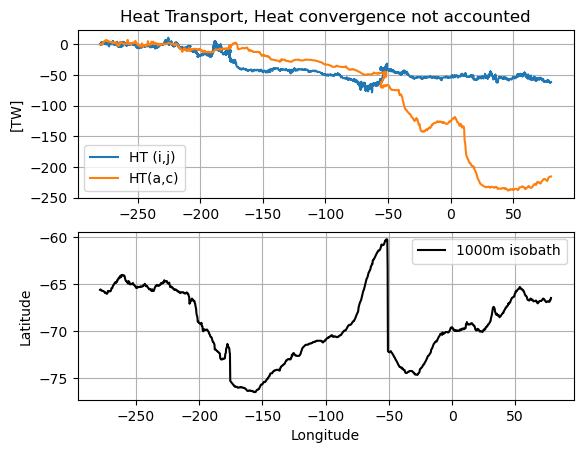

In [35]:
plt.subplot(2,1,1)
plt.plot(HTz.lon_along_contour,np.cumsum(Oheat_trans_across_contour)/1e12,label='HT (i,j)')
plt.plot(lon_along_contour[:-1],np.cumsum(Ftemp_cross_contour_filled[:-1])/1e12,label='HT(a,c)')
plt.title("Heat Transport, Heat convergence not accounted")
plt.ylabel('[TW]')

plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(HTz.lon_bin_midpoints,HTz.lat_bin_midpoints,color='black',label='1000m isobath')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()

In [71]:
# fig = plt.figure(figsize=(6,7))
# plt.subplot(2,1,1)
# plt.plot(HTz.lon_bin_midpoints,np.cumsum(Ocross_slope_heat_trans + Ozonal_convergence)/1e12,label='HT + HC on (i,j)')
# #plt.plot(HTz.lon_bin_midpoints,np.cumsum(cross_slope_heat_trans),label='HT(x,y)')
# plt.plot(HTz.lon_bin_midpoints,np.cumsum(Ocross_slope_heat_trans)/1e12,label='HT on (i,j)')
# plt.plot(lon_along_contour[:-1],np.cumsum(Ftemp_cross_contour_filled[:-1])/1e12,label='HT(along,cross)')
# plt.plot(HTz.lon_bin_midpoints,np.cumsum(Ocross_slope_heat_trans)/1e12,color="tab:blue")
# plt.grid()
# plt.xlabel('Longitude')
# plt.ylabel('TW')
# plt.legend()
# plt.title("Jan - Heat transports across 1000m isobath (HT)")

# plt.subplot(2,1,2)
# plt.plot(HTz.lon_bin_midpoints,HTz.lat_bin_midpoints)
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid()

In [72]:
# Binning by distance

bin_width = 300 #min 35 km, 3 deg of lon, in around 65S is equivalen to 140 km
bin_spacing = 13 # chose 13 km, which is similar to the value uswd for binning (in degrees, 0.25) at 65S
alon_west = 0
alon_east = distance_along_contour[-2]

# # new coordinate and midpoints of longitude bins:
full_alon_coord = np.arange(alon_west,alon_east+bin_spacing,bin_spacing)
alon_bin_midpoints = np.arange(alon_west+bin_width/2,alon_east-bin_width/2,bin_spacing)
n_bin_edges = len(full_alon_coord)
bin_edge_indices = np.zeros(n_bin_edges)
Ftemp_cross_contour_binned=np.zeros(np.size(full_alon_coord))
lon_along_binned=np.zeros(np.size(full_alon_coord))
lat_along_binned=np.zeros(np.size(full_alon_coord))
lon_west_edge=np.zeros(np.size(full_alon_coord))
lon_east_edge=np.zeros(np.size(full_alon_coord))
lat_west_edge=np.zeros(np.size(full_alon_coord))
lat_east_edge=np.zeros(np.size(full_alon_coord))

lon_along_contourn=lon_along_contour[:-1]
lat_along_contourn=lat_along_contour[:-1]
distance_along_contourn=distance_along_contour[:-1]


for alon_bin in range(np.size(full_alon_coord-1)):
    binrange= np.array([full_alon_coord[alon_bin]-bin_width, full_alon_coord[alon_bin]+bin_width]) # in km
    
    #fixing the edges on binrange
    binrange[binrange<0]=0
    binrange[binrange>distance_along_contourn[-1]]=distance_along_contourn[-1]
    #print(binrange)
    #Indexes of selected values for each bin
    array_inds = np.argwhere((distance_along_contourn>binrange[0]) & (distance_along_contourn<binrange[1]))
    #Actual values for each bin
    array_vals = distance_along_contourn[array_inds]
    
    #Binning Ftemp
    Ftemp_cross_contour_binned[alon_bin] = np.nansum(Ftemp_cross_contour[array_inds])
    lon_along_binned[alon_bin] = np.nanmean(lon_along_contourn[array_inds])
    lon_west_edge[alon_bin] = lon_along_contourn[array_inds[0]]
    lon_east_edge[alon_bin] = lon_along_contourn[array_inds[-1]]
    lat_west_edge[alon_bin] = lat_along_contourn[array_inds[0]]
    lat_east_edge[alon_bin] = lat_along_contourn[array_inds[-1]]
    lat_along_binned[alon_bin] = np.nanmean(lat_along_contourn[array_inds])

    
    
Ftemp_convergence_binned=np.zeros(np.size(full_alon_coord))
for alon_bin in range(np.size(full_alon_coord)):
    binrange= np.array([full_alon_coord[alon_bin]-bin_width, full_alon_coord[alon_bin]+bin_width]) # in km
    
    #fixing the edges on binrange
    binrange[binrange<0]=0
    binrange[binrange>distance_along_contourn[-1]]=distance_along_contourn[-1]
    
    #Indexes of selected values for each bin
    array_inds = np.argwhere((distance_along_contourn>binrange[0]) & (distance_along_contourn<binrange[1]))
    #Actual values for each bin
    array_vals = distance_along_contourn[array_inds]
    
    
    #Ftemp_convergence_binned[alon_bin] = -Ftemp_along_contour[array_inds[0]] + Ftemp_along_contour[array_inds[-1]]
    Ftemp_convergence_binned[alon_bin] = -Ftempx_contour[array_inds[0]] + Ftempx_contour[array_inds[-1]]

#calculating the factor
factoralong=np.nansum(Ftemp_cross_contour_filled)/np.nansum(Ftemp_cross_contour_binned+Ftemp_convergence_binned)



        
Ftemp_convergence_binned=np.nan_to_num(Ftemp_convergence_binned)
Ftemp_cross_contour_binned=np.nan_to_num(Ftemp_cross_contour_binned)




In [73]:
def running_mean(x, N):
    cumsum = np.nancumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [74]:
def geodistance(latarray,lonarray):
    import geopy.distance
    geodkm = np.zeros(np.size(latarray))
    for n in np.arange(1,np.size(latarray)-1):
        coords_1 = (latarray[n], lonarray[n])
        coords_2 = (latarray[n+1], lonarray[n+1])
        geodkm[n] = geopy.distance.geodesic(coords_1, coords_2).m
    return geodkm

In [75]:
deltam_along = geodistance(lat_along_binned,lon_along_binned)
deltam_along[deltam_along == 0] = np.nan
deltam_ij = geodistance(HTz.lat_bin_midpoints,HTz.lon_bin_midpoints)
deltam_ij[deltam_ij == 0] = np.nan

In [76]:
# # Creating an array of cross-slope heat transport to compare with 
# # results from figure 3c from Stewart et al 2018
# AW=100
# AW2=10
# AW3=50
# lon_along_binned[254]+360
# lon_along_setwart=np.append(lon_along_binned[254:],lon_along_binned[:254]+360)
# cross_along_setwart=np.append(Ftemp_cross_contour_binned[254:],Ftemp_cross_contour_binned[:254])


# factor = np.nansum(HTz.heat_trans_across_contour)/(np.nansum(HTz.cross_slope_heat_trans)+np.nansum(HTz.zonal_convergence))
# HTz.lon_bin_midpoints[254]+360

# lon_ij_setwart=np.append(HTz.lon_bin_midpoints[254:],HTz.lon_bin_midpoints[:254]+360)
# lon_ijubinned_setwart=np.append(HTz.lon_along_contour[900:],HTz.lon_along_contour[:900]+360)


# HT_ijubinned_setwart=np.append(HTz.heat_trans_across_contour[900:],HTz.heat_trans_across_contour[:900]+360)

# cross_ij_setwart=np.append(HTz.cross_slope_heat_trans[254:],HTz.cross_slope_heat_trans[:254]+360)*factor
# convergence_ij_setwart=np.append(HTz.zonal_convergence[254:],HTz.zonal_convergence[:254]+360)*factor
# Dcross_ij_setwart = cross_ij_setwart + convergence_ij_setwart



# plt.plot(running_mean(lon_along_setwart,AW), running_mean(cross_along_setwart,AW),label='(a,c): no convergence')
# plt.plot(running_mean(lon_ij_setwart,AW2), running_mean(cross_ij_setwart,AW2),label='(i,j): no convergence')
# plt.plot(running_mean(lon_ij_setwart,AW2), running_mean(Dcross_ij_setwart,AW2),label='(i,j): + convergence')
# #plt.plot(running_mean(lon_ijubinned_setwart,AW3), running_mean(HT_ijubinned_setwart,AW3),label='(i,j): unbinned')




# plt.xlim(50,140)
# plt.grid()
# plt.xlabel("Longitude")
# plt.ylabel("MW")
# plt.legend()
# plt.ylim(-4e12,4e12)
# #The (a,c) plot looks a little bit like the Fig 3c, total line. 

In [77]:
# # Binning along contour. This binning here is done by number of points. I need to try to bin by distance instead
# # in degrees:
# bin_width = 30 #6,12,12,12
# bin_spacing = 3 # 3,5,10,20. Chose 3 cause it is ~ the same distance in km that was used to binning along longs (~11km)
# alon_west = 0
# alon_east = num_points

# # # new coordinate and midpoints of longitude bins:
# full_alon_coord = np.arange(alon_west,alon_east+bin_spacing,bin_spacing)
# alon_bin_midpoints = np.arange(alon_west+bin_width/2,alon_east-bin_width/2,bin_spacing)
# n_bin_edges = len(full_alon_coord)
# bin_edge_indices = np.zeros(n_bin_edges)
# Ftemp_cross_contour_binned=np.zeros(np.size(full_alon_coord))
# lon_along_binned=np.zeros(np.size(full_alon_coord))
# lat_along_binned=np.zeros(np.size(full_alon_coord))

# lon_along_contourn=lon_along_contour[:-1]
# lat_along_contourn=lat_along_contour[:-1]
# #np.shape(alon_bin_midpoints)
# for alon_bin in range(np.size(full_alon_coord-1)):
#     binrange= np.array([full_alon_coord[alon_bin]-bin_width, full_alon_coord[alon_bin]+bin_width])
#     binrange[binrange >2279] = binrange[binrange >2279]-2280
#     #To collate the edges
#     if binrange[0]<0:
#             #print(binrange)
#             Ftemp_cross_contour_binned[alon_bin] = np.nanmean(Ftemp_cross_contour[binrange[1]:binrange[0]])
#     elif binrange[0]>2000 and binrange[1]<2000:
#             #print(binrange)
#             Ftemp_cross_contour_binned[alon_bin] = np.nanmean([Ftemp_cross_contour[binrange[0]:]]) + \
#             np.nanmean([Ftemp_cross_contour[:binrange[1]]]) 
#     else:
#         Ftemp_cross_contour_binned[alon_bin] = np.nanmean(Ftemp_cross_contour[binrange[0]:binrange[1]])
#     lon_along_binned[alon_bin] = np.nanmean(lon_along_contourn[binrange[0]:binrange[1]])
#     lat_along_binned[alon_bin] = np.nanmean(lat_along_contourn[binrange[0]:binrange[1]])
# Ftemp_cross_contour_binned=np.nan_to_num(Ftemp_cross_contour_binned)

# #now calculating the heat convergence
# Ftemp_convergence_binned=np.zeros(np.size(full_alon_coord))
# for alon_bin in range(np.size(full_alon_coord)):
#     binrange= np.array([full_alon_coord[alon_bin]-bin_width, full_alon_coord[alon_bin]+bin_width])
#     binrange[binrange >2279] = binrange[binrange >2279]-2280
#     #print(Ftemp_along_contour[binrange[0]] - Ftemp_along_contour[binrange[1]])
#     Ftemp_convergence_binned[alon_bin] = Ftemp_along_contour[binrange[0]] - Ftemp_along_contour[binrange[1]]
# Ftemp_convergence_binned=np.nan_to_num(Ftemp_convergence_binned)


# #calculating the factor
# factoralong=np.nansum(Ftemp_cross_contour_filled)/np.nansum(Ftemp_cross_contour_binned+Ftemp_convergence_binned)
# factoralong2=np.nansum(Ftemp_cross_contour_filled)/np.nansum(Ftemp_cross_contour_binned)

In [78]:
#Binning along the longitude the HT(a,c) to see if the convergences are similar

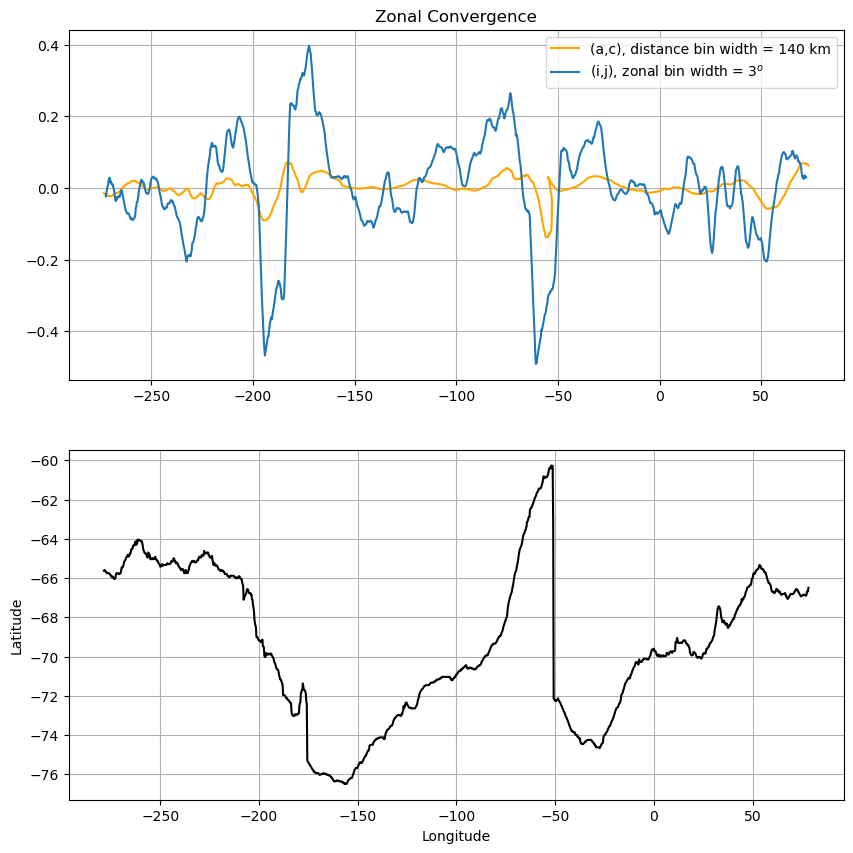

In [79]:
fig = plt.figure(figsize=(10,10))
swin=50
plt.subplot(2,1,1)
plt.plot(running_mean(lon_along_binned,swin),running_mean(Ftemp_convergence_binned*factoralong,swin)/1e12,color="orange",label="(a,c), distance bin width = 140 km")
plt.plot(running_mean(np.array(HTz.lon_bin_midpoints),swin),running_mean(np.array(HTz.zonal_convergence*factor),swin)/1e12,color="tab:blue",label=r"(i,j), zonal bin width = 3$^{o}$")
plt.legend()
plt.grid()
plt.title("Zonal Convergence")

plt.subplot(2,1,2)
plt.plot(HTz.lon_bin_midpoints,HTz.lat_bin_midpoints,color='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()

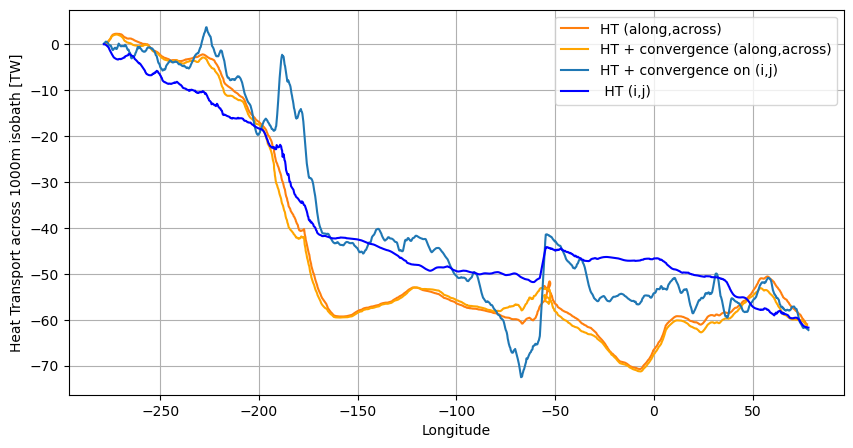

In [80]:
fig = plt.figure(figsize=(10,5))
#plt.subplot(2,1,1)
plt.plot(lon_along_binned,np.cumsum(Ftemp_cross_contour_binned)*factoralong/1e12,color="tab:orange",label="HT (along,across)")
plt.plot(lon_along_binned,np.cumsum(Ftemp_cross_contour_binned + Ftemp_convergence_binned)*factoralong/1e12,color="orange",label="HT + convergence (along,across)")
plt.plot(HTz.lon_bin_midpoints,np.cumsum(HTz.cross_slope_heat_trans*factor)/1e12,color="tab:blue",label='HT + convergence on (i,j)')
plt.plot(HTz.lon_bin_midpoints,np.cumsum((HTz.cross_slope_heat_trans + HTz.zonal_convergence)*factor)/1e12,color="blue",label=' HT (i,j)')
#plt.plot(lon_along_binned,np.cumsum(Ftemp_cross_contour_binned)*factoralong/1e12,color="tab:orange")


plt.grid()
plt.ylabel("Heat Transport across 1000m isobath [TW]")
plt.xlabel("Longitude")
plt.legend()

# plt.subplot(2,1,2)
# plt.plot(lon_along_binned,lat_along_binned,color='black')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid()

Text(0.5, 1.0, '3$^{o}$ longitude bin (i,j)')

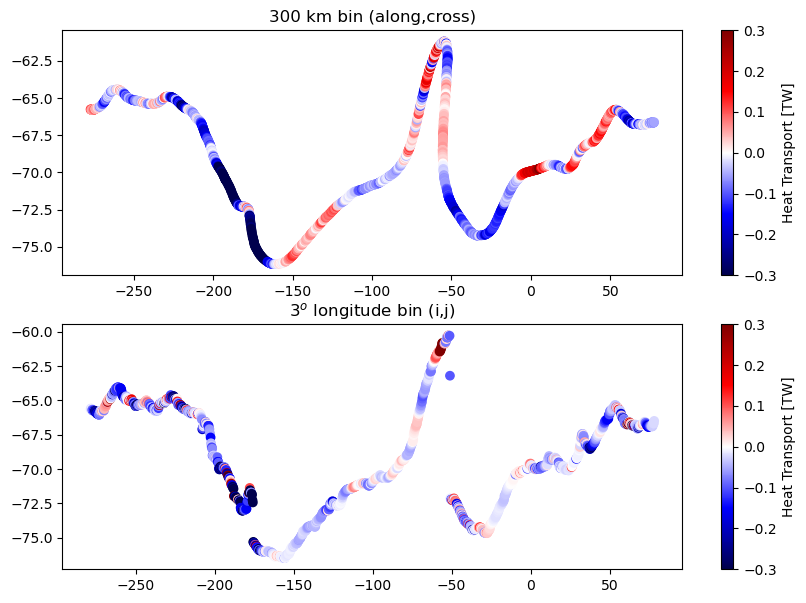

In [81]:
fig = plt.figure(figsize=(10,7))


# plt.subplot(3,1,1)
# plt.scatter(lon_along_contour,lat_along_contour,c=(Ftemp_cross_contour_filled) /1e12\
#             ,cmap='seismic',vmin=-.3,vmax=.3)
# plt.colorbar()
# plt.title("not-binned (along,cross)")

plt.subplot(2,1,1)
plt.scatter(lon_along_binned,lat_along_binned,c=(Ftemp_cross_contour_binned + Ftemp_convergence_binned)*factoralong/1e12\
            ,cmap='seismic',vmin=-.3,vmax=.3)
plt.colorbar(label='Heat Transport [TW]')
plt.title(str(bin_width) + " km bin (along,cross)")

plt.subplot(2,1,2)
plt.scatter(HTz.lon_bin_midpoints,HTz.lat_bin_midpoints,c=(HTz.cross_slope_heat_trans + HTz.zonal_convergence)*factor/1e12\
            ,cmap='seismic',vmin=-.3,vmax=.3)
plt.colorbar(label='Heat Transport [TW]')
plt.title(r"3$^{o}$ longitude bin (i,j)")

Trying to rebin it by lingitude again, to see how it differes from the original data


In [82]:
# Binning by lon

# convert to longitude coordinate and average into 3 degree longitude bins:
# in degrees:
bin_width = 3
bin_spacing = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coordL = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpointsL = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
n_bin_edgesL = len(full_lon_coordL)

bin_edge_indicesL = np.zeros(n_bin_edgesL)
Ftemp_cross_contour_Lbinned=np.zeros(np.size(full_lon_coordL))
lon_along_Lbinned=np.zeros(np.size(full_lon_coordL))
lat_along_Lbinned=np.zeros(np.size(full_lon_coordL))

lon_along_contourn=lon_along_contour[:-1]
lat_along_contourn=lat_along_contour[:-1]
distance_along_contourn=distance_along_contour[:-1]


for lon_bin in range(np.size(full_lon_coordL-1)):
    binrange= np.array([full_lon_coordL[lon_bin]-bin_width, full_lon_coordL[lon_bin]+bin_width]) # in km

    #fixing the edges on binrange
    binrange[binrange<-280]=-280
    binrange[binrange>80]=80

    #binrange[binrange>lon_along_contourn[-1]]=lon_along_contourn[-1]

    #Indexes of selected values for each bin
    array_inds = np.argwhere((lon_along_contourn>binrange[0]) & (lon_along_contourn<binrange[1]))

    #Actual values for each bin
    array_vals = lon_along_contourn[array_inds]

    
    #Binning Ftemp
    Ftemp_cross_contour_Lbinned[lon_bin] = np.nansum(Ftemp_cross_contour[array_inds])
    lon_along_Lbinned[lon_bin] = np.nanmean(lon_along_contourn[array_inds])
    lat_along_Lbinned[lon_bin] = np.nanmean(lat_along_contourn[array_inds])

    
    
Ftemp_convergence_Lbinned=np.zeros(np.size(full_lon_coordL))
for lon_bin in range(np.size(full_lon_coordL)):
    binrange= np.array([full_lon_coordL[lon_bin]-bin_width, full_lon_coordL[lon_bin]+bin_width]) # in km

    #fixing the edges on binrange
    binrange[binrange<-280]=-280
    binrange[binrange>80]=80

    
    #Indexes of selected values for each bin
    array_inds = np.argwhere((lon_along_contourn>binrange[0]) & (lon_along_contourn<binrange[1]))

    #Actual values for each bin
    array_vals = lon_along_contourn[array_inds]

    
    
    Ftemp_convergence_Lbinned[lon_bin] = -Ftemp_along_contour[array_inds[0]] + Ftemp_along_contour[array_inds[-1]]

    
    
Ftemp_convergence_Lbinned=np.nan_to_num(Ftemp_convergence_Lbinned)
Ftemp_cross_contour_Lbinned=np.nan_to_num(Ftemp_cross_contour_Lbinned)


#calculating the factor
factoralongL=np.nansum(Ftemp_cross_contour)/np.nansum(Ftemp_cross_contour_Lbinned+Ftemp_convergence_Lbinned)


In [112]:
%%time
#This calculation is very very slow. It might take up to 40 min to run this particular cell
Atemp_x_along_contour = np.zeros(np.size(HTz.lon_along_contour))
temp_xflux0=temp_xflux.isel(time=0);

for n in np.arange(0,np.size(HTz.lon_along_contour)):
    Atemp_x_along_contour[n] = temp_xflux0.sel(xu_ocean=Alon_along_contour[n],yt_ocean=Alat_along_contour[n],method='nearest')

CPU times: user 9min 59s, sys: 2min 9s, total: 12min 9s
Wall time: 18min 11s


In [113]:
# Binning by lon

# convert to longitude coordinate and average into 3 degree longitude bins:
# in degrees:
Abin_width = 3
Abin_spacing = 0.25
Alon_west = -280
Alon_east = 80

# new coordinate and midpoints of longitude bins:
Afull_lon_coordL = np.arange(Alon_west,Alon_east+Abin_spacing,Abin_spacing)
Alon_bin_midpointsL = np.arange(Alon_west+Abin_width/2,Alon_east-Abin_width/2,Abin_spacing)
An_bin_edgesL = len(Afull_lon_coordL)
Adistance=np.cumsum(np.nan_to_num(deltam_ij))/1000
Abin_edge_indicesL = np.zeros(An_bin_edgesL)
AFtemp_cross_contour_Lbinned=np.zeros(np.size(Afull_lon_coordL))
Alon_along_Lbinned=np.zeros(np.size(Afull_lon_coordL))
Alat_along_Lbinned=np.zeros(np.size(Afull_lon_coordL))

Alon_along_contourn=np.array(HTz.lon_along_contour)
#Alat_along_contourn=HTz.lat_along_contour
AHT=np.array(HTz.heat_trans_across_contour)
distance_along_contourn=Adistance

AAHT=np.zeros(np.size(Afull_lon_coordL))
for Alon_bin in range(np.size(Afull_lon_coordL-1)):
    Abinrange= np.array([Afull_lon_coordL[Alon_bin]-Abin_width, Afull_lon_coordL[Alon_bin]+Abin_width]) # in km

    #fixing the edges on binrange
    Abinrange[Abinrange<-280]=-280
    Abinrange[Abinrange>80]=80

    #binrange[binrange>lon_along_contourn[-1]]=lon_along_contourn[-1]

    #Indexes of selected values for each bin
    Aarray_inds = np.argwhere((Alon_along_contourn>Abinrange[0]) & (Alon_along_contourn<Abinrange[1]))

    #Actual values for each bin
    Aarray_vals = Alon_along_contourn[Aarray_inds]

    
    #Binning Ftemp
    AAHT[Alon_bin] = np.nansum(AHT[Aarray_inds])
    Alon_along_Lbinned[lon_bin] = np.nanmean(Alon_along_contourn[array_inds])
    #Alat_along_Lbinned[lon_bin] = np.nanmean(Alat_along_contourn[array_inds])

    
    
AAHC=np.zeros(np.size(Afull_lon_coordL))
for Alon_bin in range(np.size(Afull_lon_coordL)):
    Abinrange= np.array([Afull_lon_coordL[Alon_bin]-Abin_width, Afull_lon_coordL[Alon_bin]+Abin_width]) # in km

    #fixing the edges on binrange
    Abinrange[Abinrange<-280]=-280
    Abinrange[Abinrange>80]=80

    
    #Indexes of selected values for each bin
    Aarray_inds = np.argwhere((Alon_along_contourn>Abinrange[0]) & (Alon_along_contourn<Abinrange[1]))

    #Actual values for each bin
    Aarray_vals = Alon_along_contourn[Aarray_inds]

    
    
    AAHC[Alon_bin] = -AHT[Aarray_inds[0]] + AHT[Aarray_inds[-1]]

    
    
AAHC=np.nan_to_num(AAHC)
AAHT=np.nan_to_num(AAHT)


#calculating the factor
factoralongAH=np.nansum(AHT)/np.nansum(AAHT+AAHC)



In [ ]:
plt.plot(np.cumsum(AAHC+AAHT))

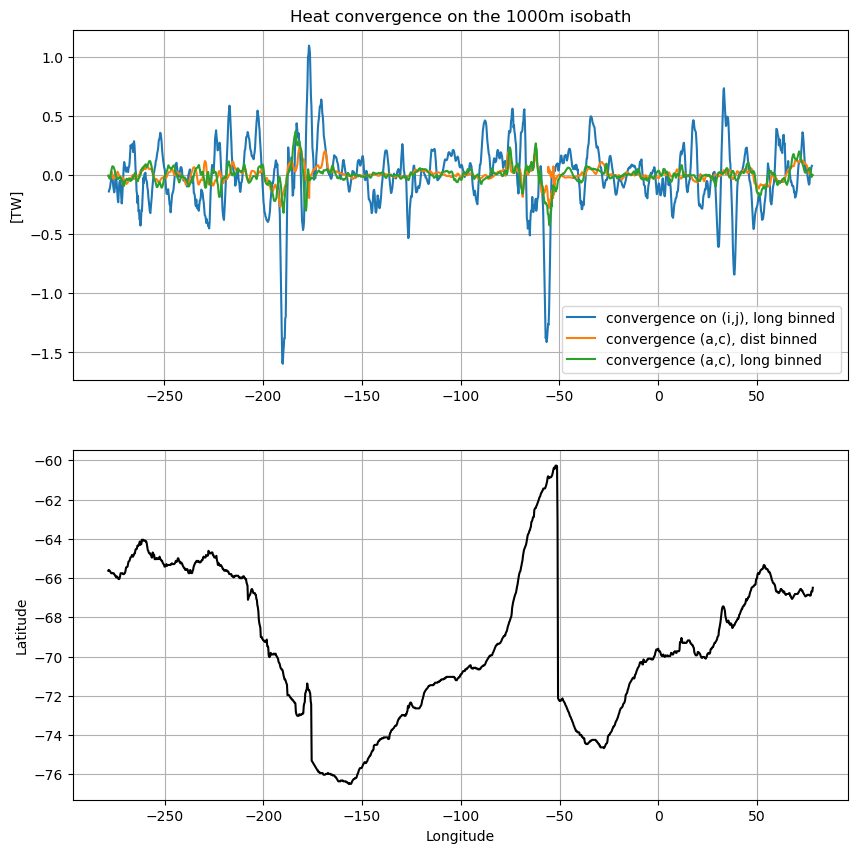

In [79]:
fig = plt.figure(figsize=(10,10))
swin=5
plt.subplot(2,1,1)
plt.plot(running_mean(np.array(HTz.lon_bin_midpoints),swin),running_mean(np.array(HTz.zonal_convergence*factor),swin)/1e12,label='convergence on (i,j), long binned')
plt.plot(running_mean(lon_along_binned,swin),running_mean(Ftemp_convergence_binned*factoralong,swin)/1e12,label="convergence (a,c), dist binned")
plt.plot(running_mean(lon_along_Lbinned,swin),running_mean(Ftemp_convergence_Lbinned*factoralongL,swin)/1e12,label="convergence (a,c), long binned")
plt.legend()
plt.grid()
plt.ylabel('[TW]')
plt.title("Heat convergence on the 1000m isobath")

plt.subplot(2,1,2)
plt.plot(HTz.lon_bin_midpoints,HTz.lat_bin_midpoints,color='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()

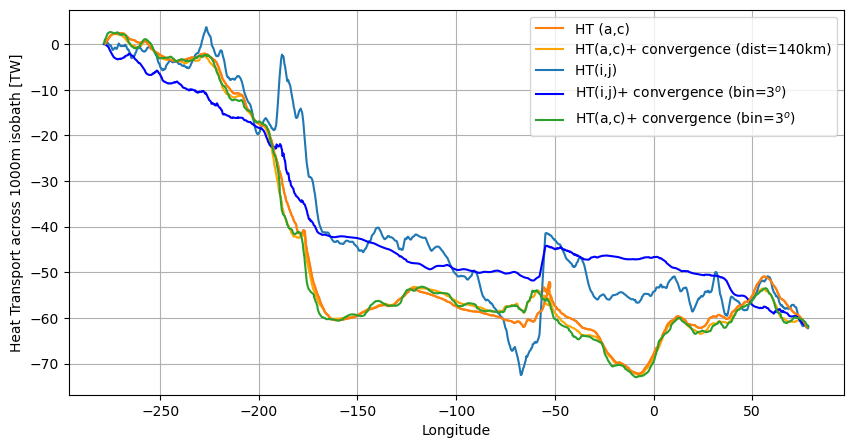

In [80]:
fig = plt.figure(figsize=(10,5))
#plt.subplot(2,1,1)
plt.plot(lon_along_binned,np.cumsum(Ftemp_cross_contour_binned)*factoralong/1e12,color="tab:orange",label="HT (a,c)")
plt.plot(lon_along_binned,np.cumsum(Ftemp_cross_contour_binned + Ftemp_convergence_binned)*factoralong/1e12,color="orange",label="HT(a,c)+ convergence (dist=140km)")
plt.plot(HTz.lon_bin_midpoints,np.cumsum(HTz.cross_slope_heat_trans*factor)/1e12,color="tab:blue",label=r"HT(i,j) ")
plt.plot(HTz.lon_bin_midpoints,np.cumsum((HTz.cross_slope_heat_trans + HTz.zonal_convergence)*factor)/1e12,color="blue",label='HT(i,j)+ convergence (bin=3$^{o}$)')
plt.plot(lon_along_binned,np.cumsum(Ftemp_cross_contour_binned)*factoralong/1e12,color="tab:orange")
plt.plot(lon_along_Lbinned,np.cumsum(Ftemp_cross_contour_Lbinned+Ftemp_convergence_Lbinned)*factoralongL/1e12,color="tab:green",label="HT(a,c)+ convergence (bin=3$^{o}$) ")




plt.grid()
plt.ylabel("Heat Transport across 1000m isobath [TW]")
plt.xlabel("Longitude")
plt.legend()

# plt.subplot(2,1,2)
# plt.plot(lon_along_binned,lat_along_binned,color='black')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid()

In [150]:
# We gota first figure out how the convergence look when binning zonally
# #Saving file
# #outpath = '/g/data/x77/wf4500/ASC_project/Cross_slope_transport/Montlhy/Ant_cross_slope_heat_terms_online_'+str(isobath_depth)+'m_'+start_str+'.nc'
# outpath = '/g/data/x77/wf4500/ASC_project/test_cross_slope_transport_acSpace.nc'


# CLHT=xr.DataArray((Ftemp_cross_contour_filled),name="cross_slope_heat_trans",dims=["lon_along_contour"])
# CLHTb=xr.DataArray((Ftemp_cross_contour_binned),name="cross_slope_heat_trans_binned",dims=["lon_bin_midpoints"])


# data_to_save = xr.merge([CLHT,CLHTb])
# data_to_save['lon_along_contour']=np.array(lon_along_contour)
# data_to_save['lat_along_contour']=np.array(lat_along_contour)
# data_to_save['lon_bin_midpoints']=np.array(lon_along_binned)
# data_to_save['lat_bin_midpoints']=np.array(lat_along_binned)

# data_to_save.to_netcdf(outpath)

In [286]:
# %%time
# temp_yflux = temp_yflux.load()
# temp_xflux = temp_xflux.load()

In [88]:
# temp_yflux_with_mask = temp_yflux*mask_y_transport
# temp_xflux_with_mask = temp_xflux*mask_x_transport

In [89]:
# %%time
# temp_yflux_with_mask = temp_yflux_with_mask.load()


In [90]:
# %%time
# temp_xflux_with_mask = temp_xflux_with_mask.load()

## Extract heat transport values along isobath contour:

In [99]:
## THIS IS THE ORIGINAL CELL, BEFORE ANY OF MY EDITS
# multiply by mask to get correct direction into or out of isobath contour:
num_points2 = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))
heat_trans_across_contour = np.zeros((num_points2))

# locations for zonal transport, already calculated indices above:
for count in x_indices:
    count = int(count)
    jj = int(np.where(mask_x_transport_numbered==count)[0])
    ii = int(np.where(mask_x_transport_numbered==count)[1])
    heat_trans_across_contour[count-1] += temp_xflux_with_mask[jj,ii]
    
# locations for meridional transport, already calculated indices above:
for count in y_indices:
    count = int(count)
    jj = int(np.where(mask_y_transport_numbered==count)[0])
    ii = int(np.where(mask_y_transport_numbered==count)[1])
    heat_trans_across_contour[count-1] += temp_yflux_with_mask[jj,ii]

In [220]:
# # multiply by mask to get correct direction into or out of isobath contour:
# num_points2 = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))
# heat_trans_across_contour = np.zeros((num_points2))

# # locations for zonal transport, already calculated indices above:
# for count in x_indices:
#     count = int(count)
#     jj = int(np.where(mask_x_transport_numbered==count)[0])
#     ii = int(np.where(mask_x_transport_numbered==count)[1])
#     heat_trans_across_contour[count-1] += temp_xflux_with_mask[jj,ii]
    
# # locations for meridional transport, already calculated indices above:
# for count in y_indices:
#     count = int(count)
#     jj = int(np.where(mask_y_transport_numbered==count)[0])
#     ii = int(np.where(mask_y_transport_numbered==count)[1])
#     heat_trans_across_contour[count-1] += temp_yflux_with_mask[jj,ii]

## Convert cross-slope heat transport from isobath coordinate to longitude coordinate

In [191]:
# ## THIS IS THE ORIGINAL CELLS, BEFORE ANY EDDITING
# # convert to longitude coordinate and average into 3 degree longitude bins:
# # in degrees:
# bin_width = 3
# bin_spacing = 0.25
# lon_west = -280
# lon_east = 80

# # new coordinate and midpoints of longitude bins:
# full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
# lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
# n_bin_edges = len(full_lon_coord)

# # sum into longitude bins:
# # need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# # on the isobath contour and sum continously along contour between defined indices.
# # (i.e. lon_along_contour is not monotonic)
# # find points on contour to define edges of longitude bins:
# bin_edge_indices = np.zeros(n_bin_edges)
# for lon_bin in range(n_bin_edges-1):
#     # find first isobath point that has the right longitude:
#     first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
#     # then find all other isobath points with the same longitude as that first point:
#     same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
#     # we want the most southerly of these points on the same longitude line:
#     bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
    
# # define east/west edges:
# bin_edge_indices = bin_edge_indices.astype(int)
# bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
# bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
# n_bins = len(bin_edge_indices_west)

# # sum heat transport from isobath coord into new longitude coord:
# cross_slope_heat_trans = np.zeros(n_bins)
# for lon_bin in range(n_bins):
#     heat_trans_this_bin = heat_trans_across_contour[bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
#     cross_slope_heat_trans[lon_bin] = np.sum(heat_trans_this_bin)
    
# # find average latitude of each bin, so we can plot back on the isobath:
# lat_bin_midpoints = np.zeros(n_bins)
# for lon_bin in range(n_bins):
#     # find nearest isobath point:
#     lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
#     lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]

In [228]:
# convert to longitude coordinate and average into 3 degree longitude bins:
# in degrees:
bin_width_a = 3
bin_spacing_a = 0.25
lon_west_a = -280
lon_east_a = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord_a = np.arange(lon_west_a,lon_east_a+bin_spacing_a,bin_spacing_a)
lon_bin_midpoints_a = np.arange(lon_west_a+bin_width_a/2,lon_east_a-bin_width_a/2,bin_spacing_a)
n_bin_edges_a = len(full_lon_coord_a)

# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices_a = np.zeros(n_bin_edges_a)
for lon_bin in range(n_bin_edges_a-1):
    # find first isobath point that has the right longitude:
    first_point_a = np.where(lon_along_contour>=full_lon_coord_a[lon_bin])[0][0]
    # then find all other isobath points with the same longitude as that first point:
    same_lon_points_a = np.where(lon_along_contour==lon_along_contour[first_point_a])[0]
    # we want the most southerly of these points on the same longitude line:
    bin_edge_indices_a[lon_bin] = same_lon_points_a[np.argmin(lat_along_contour[same_lon_points_a])]
    
# define east/west edges:
bin_edge_indices_a = bin_edge_indices_a.astype(int)
bin_edge_indices_west_a = bin_edge_indices_a[:-int(bin_width_a/bin_spacing_a)-1]
bin_edge_indices_east_a = bin_edge_indices_a[int(bin_width_a/bin_spacing_a):-1]
n_bins_a = len(bin_edge_indices_west_a)

# sum heat transport from isobath coord into new longitude coord:
cross_slope_heat_trans_a = np.zeros(n_bins_a)
for lon_bin in range(n_bins_a):
    heat_trans_this_bin_a = Ftemp_cross_contour_filled[bin_edge_indices_west_a[lon_bin]:bin_edge_indices_east_a[lon_bin]]
    cross_slope_heat_trans_a[lon_bin] = np.sum(heat_trans_this_bin_a)
    
# find average latitude of each bin, so we can plot back on the isobath:
lat_bin_midpoints_a = np.zeros(n_bins_a)
for lon_bin in range(n_bins_a):
    # find nearest isobath point:
    lon_index_a = np.where(lon_along_contour>=lon_bin_midpoints_a[lon_bin])[0][0]
    lat_bin_midpoints_a[lon_bin] = lat_along_contour[lon_index_a]

Longitudinal bins seem to work on most of the contour, but not in the EAP and in a small region in the ROss Sea, because those locations isobaths are mostly meridional. So in these locations it makes more sense to calculate the meridional divergence. I will then calculate **meridional convergence** for the whole contour,and then substitute these location in the original convergence dataset

In [94]:
temp_xflux=temp_xflux[0]
temp_yflux=temp_yflux[0]

## Zonal heat convergence

In [27]:
## ORIGINAL ONE, DO NOT DELETE IT
# # Need to make sure the zonal boundaries here match exactly with the zonal boundaries used for the 
# # longitude averaging above, by using same bin_edge_indices.
# # Just check if isobath point is on x or y grid. if x, sum up to this point from south.
# # if on y grid, sum zonal transport on nearest u grid point to west.

# zonal_heat_trans_west = np.zeros(n_bins)
# for lon_bin in range(n_bins):
#     # west limit:
#     # reset these to False:
#     on_x_grid = False
#     on_y_grid = False
#     # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
#     isobath_west_index = int(bin_edge_indices_west[lon_bin]+1)
#     # check if the point is on the x or y transport grid:
#     if len(np.where(mask_x_transport_numbered==isobath_west_index)[0])>0:
#         on_x_grid = True
#         jj = int(np.where(mask_x_transport_numbered==isobath_west_index)[0])
#         ii = int(np.where(mask_x_transport_numbered==isobath_west_index)[1])
#     elif len(np.where(mask_y_transport_numbered==isobath_west_index)[0])>0:
#         on_y_grid = True
#         jj = int(np.where(mask_y_transport_numbered==isobath_west_index)[0])
#         ii = int(np.where(mask_y_transport_numbered==isobath_west_index)[1])
#     if on_x_grid == True:
#         zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj,ii])
#     # in this case we want transport half a grid point to the west:
#     elif on_y_grid == True:
#         # careful if ii=0, then we need heat trans from lon=80, because at limit of zonal grid
#         if ii==0:
#             zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
#         else:
#             zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj+1,ii-1])

# zonal_heat_trans_east = np.zeros(n_bins)
# for lon_bin in range(n_bins):
#     # east limit:
#     # reset these to False:
#     on_x_grid = False
#     on_y_grid = False
#     # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
#     isobath_east_index = int(bin_edge_indices_east[lon_bin]+1)
#     # check if the point is on the x or y transport grid:
#     if len(np.where(mask_x_transport_numbered==isobath_east_index)[0])>0:
#         on_x_grid = True
#         jj = int(np.where(mask_x_transport_numbered==isobath_east_index)[0])
#         ii = int(np.where(mask_x_transport_numbered==isobath_east_index)[1])
#     elif len(np.where(mask_y_transport_numbered==isobath_east_index)[0])>0:
#         on_y_grid = True
#         jj = int(np.where(mask_y_transport_numbered==isobath_east_index)[0])
#         ii = int(np.where(mask_y_transport_numbered==isobath_east_index)[1])
#     if on_x_grid == True:
#         zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj,ii])
#     # in this case we want transport half a grid point to the west:
#     elif on_y_grid == True:
#         # wrap around to east side of grid:
#         if ii==0:
#             zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
#         else:
#             zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,ii-1])

# zonal_convergence = zonal_heat_trans_east - zonal_heat_trans_west

In [235]:
# Need to make sure the zonal boundaries here match exactly with the zonal boundaries used for the 
# longitude averaging above, by using same bin_edge_indices.
# Just check if isobath point is on x or y grid. if x, sum up to this point from south.
# if on y grid, sum zonal transport on nearest u grid point to west.

zonal_heat_trans_west_a = np.zeros(n_bins_a)
for lon_bin in range(n_bins_a):
    # west limit:
    # reset these to False:
    on_x_grid = False
    on_y_grid = False
    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
    isobath_west_index_a = int(bin_edge_indices_west_a[lon_bin]+1)
    # check if the point is on the x or y transport grid:
    if len(np.where(mask_x_transport_numbered==isobath_west_index_a)[0])>0:
        on_x_grid = True
        jj = int(np.where(mask_x_transport_numbered==isobath_west_index_a)[0])
        ii = int(np.where(mask_x_transport_numbered==isobath_west_index_a)[1])
    elif len(np.where(mask_y_transport_numbered==isobath_west_index_a)[0])>0:
        on_y_grid = True
        jj = int(np.where(mask_y_transport_numbered==isobath_west_index_a)[0])
        ii = int(np.where(mask_y_transport_numbered==isobath_west_index_a)[1])
    if on_x_grid == True:
        zonal_heat_trans_west_a[lon_bin] = np.sum(Ftemp_along[:jj,ii])
    # in this case we want transport half a grid point to the west:
    elif on_y_grid == True:
        # careful if ii=0, then we need heat trans from lon=80, because at limit of zonal grid
        if ii==0:
            zonal_heat_trans_west_a[lon_bin] = np.sum(Ftemp_along[:jj+1,-1])
        else:
            zonal_heat_trans_west_a[lon_bin] = np.sum(Ftemp_along[:jj+1,ii-1])

zonal_heat_trans_east_a = np.zeros(n_bins_a)
for lon_bin in range(n_bins_a):
    # east limit:
    # reset these to False:
    on_x_grid = False
    on_y_grid = False
    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
    isobath_east_index_a = int(bin_edge_indices_east_a[lon_bin]+1)
    # check if the point is on the x or y transport grid:
    if len(np.where(mask_x_transport_numbered==isobath_east_index_a)[0])>0:
        on_x_grid = True
        jj = int(np.where(mask_x_transport_numbered==isobath_east_index_a)[0])
        ii = int(np.where(mask_x_transport_numbered==isobath_east_index_a)[1])
    elif len(np.where(mask_y_transport_numbered==isobath_east_index_a)[0])>0:
        on_y_grid = True
        jj = int(np.where(mask_y_transport_numbered==isobath_east_index_a)[0])
        ii = int(np.where(mask_y_transport_numbered==isobath_east_index_a)[1])
    if on_x_grid == True:
        zonal_heat_trans_east_a[lon_bin] = np.sum(Ftemp_along[:jj,ii])
    # in this case we want transport half a grid point to the west:
    elif on_y_grid == True:
        # wrap around to east side of grid:
        if ii==0:
            zonal_heat_trans_east_a[lon_bin] = np.sum(Ftemp_along[:jj+1,-1])
        else:
            zonal_heat_trans_east_a[lon_bin] = np.sum(Ftemp_along[:jj+1,ii-1])

zonal_convergence_a = zonal_heat_trans_east_a - zonal_heat_trans_west_a

In [245]:
#calculating the scaling factor
factoralong_a=np.nansum(Ftemp_cross_contour_filled)/np.nansum(cross_slope_heat_trans_a+zonal_convergence_a)


In [246]:
factoralong_a

0.04371762326900372

NameError: name 'running_mean' is not defined

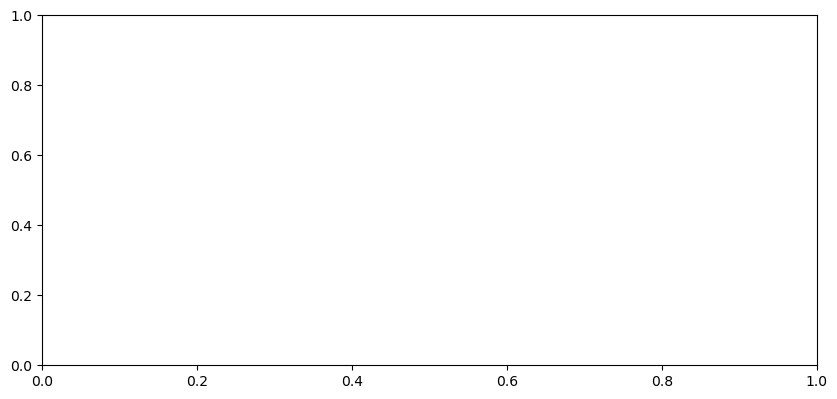

In [30]:
fig = plt.figure(figsize=(10,10))
swin=50
plt.subplot(2,1,1)
plt.plot(running_mean(np.array(HTz.lon_bin_midpoints),swin),running_mean(np.array(HTz.zonal_convergence*factor),swin)/1e12,label='convergence on (i,j), long binned')
plt.plot(running_mean(lon_along_binned,swin),running_mean(Ftemp_convergence_binned*factoralong,swin)/1e12,label="convergence (a,c), dist binned")
plt.plot(running_mean(lon_along_Lbinned,swin),running_mean(Ftemp_convergence_Lbinned*factoralongL,swin)/1e12,label="convergence (a,c), long binned")
#plt.plot(running_mean(lon_bin_midpoints_a,swin),running_mean(zonal_convergence_a*factoralong_a,swin)/1e12,label="convergence (a,c), long binned Adele")


plt.legend()
plt.grid()
plt.ylabel('[TW]')
plt.title("Heat convergence on the 1000m isobath")

plt.subplot(2,1,2)
plt.plot(HTz.lon_bin_midpoints,HTz.lat_bin_midpoints,color='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()

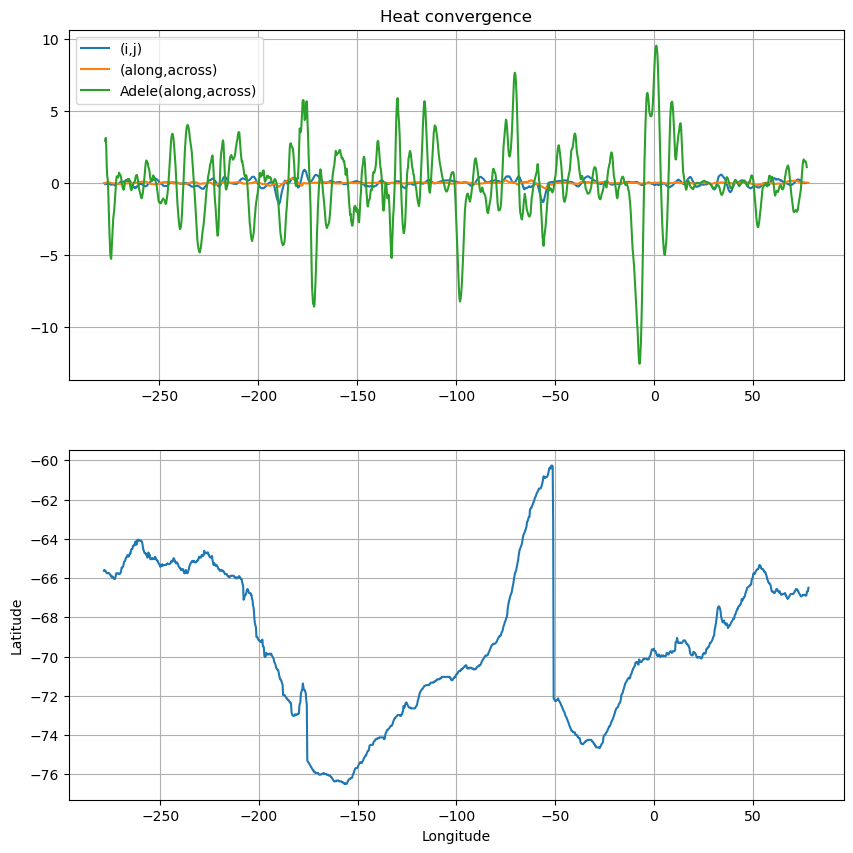

In [259]:
#checking how differente the zonal and along convergences look 
#when binned into the same long bins

fig = plt.figure(figsize=(10,10))
swin=10
plt.subplot(2,1,1)
plt.title("Heat convergence")
plt.plot(running_mean(np.array(HTz.lon_bin_midpoints),swin),running_mean(np.array(Ozonal_convergence),swin)*factoralongO/1e12,label='(i,j)')
plt.plot(running_mean(lon_along_Lbinned,swin),running_mean(Ftemp_convergence_Lbinned,swin)*factoralongL/1e12,label="(along,across)")
plt.plot(running_mean(lon_bin_midpoints,swin),running_mean(zonal_convergenceL,swin)*factoralongLo/1e12,label="Adele(along,across)")
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(HTz.lon_bin_midpoints,HTz.lat_bin_midpoints)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()

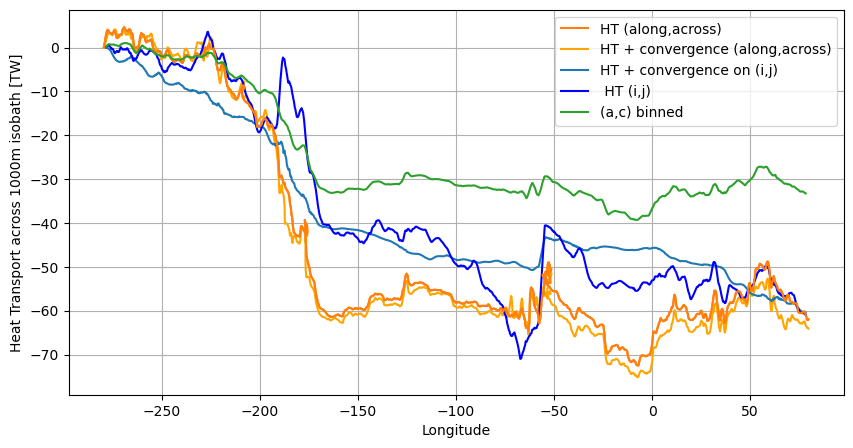

In [260]:

fig = plt.figure(figsize=(10,5))
#plt.subplot(2,1,1)
plt.plot(lon_along_binned,np.cumsum(Ftemp_cross_contour_binned)*factoralong2/1e12,color="tab:orange",label="HT (along,across)")
plt.plot(lon_along_binned,np.cumsum(Ftemp_cross_contour_binned + Ftemp_convergence_binned)*factoralong2/1e12,color="orange",label="HT + convergence (along,across)")
plt.plot(HTz.lon_bin_midpoints,np.cumsum(Dcross_slope_heat_trans)/1e12,color="tab:blue",label='HT + convergence on (i,j)')
plt.plot(HTz.lon_bin_midpoints,np.cumsum(Ocross_slope_heat_trans)/1e12,color="blue",label=' HT (i,j)')
plt.plot(lon_along_binned,np.cumsum(Ftemp_cross_contour_binned)*factoralong2/1e12,color="tab:orange")
plt.plot(lon_bin_midpoints,np.cumsum(cross_slope_heat_transL)*factoralongLo/1e12,color="tab:green",label='(a,c) binned')
#plt.plot(lon_bin_midpoints,np.cumsum(cross_slope_heat_transL + zonal_convergenceL)*factoralongLo/1e12,color="tab:green",label='(a,c) binned')
# plt.plot(lon_bin_midpoints,np.cumsum(cross_slope_heat_transL)*factoralongL/1e12,color="tab:green",label='Lon binned')




plt.grid()
plt.ylabel("Heat Transport across 1000m isobath [TW]")
plt.xlabel("Longitude")
plt.legend()

# plt.subplot(2,1,2)
# plt.plot(lon_along_binned,lat_along_binned,color='black')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid()

## Save cross-slope and zonal convergence terms for this isobath

In [28]:
# convert to data arrays, so we can save as netcdf:
zonal_convergence = xr.DataArray(zonal_convergence, coords = [('lon_bin_midpoints', lon_bin_midpoints)])
cross_slope_heat_trans = xr.DataArray(cross_slope_heat_trans, coords = [('lon_bin_midpoints', lon_bin_midpoints)])
heat_trans_across_contour = xr.DataArray(heat_trans_across_contour,coords = [('lon_along_contour',lon_along_contour)])

In [30]:
#After running this time, take off the 2 in the end of the .nc file
#outpath = '/g/data/x77/wf4500/ASC_project/Cross_slope_transport/Montlhy/Ant_cross_slope_heat_terms_online_'+str(isobath_depth)+'m_'+start_str+'.nc'
outpath = '/g/data/x77/wf4500/ASC_project/cross_slope_transport/Monthly/' + exp + '/Ant_cross_slope_heat_terms_online_'+str(isobath_depth)+'m_'+ start_time+'.nc'


ds = xr.Dataset({'zonal_convergence': zonal_convergence,'cross_slope_heat_trans':cross_slope_heat_trans,
                'lon_bin_midpoints':lon_bin_midpoints,'lat_bin_midpoints':lat_bin_midpoints,
                 'bin_width':bin_width,'bin_spacing':bin_spacing,'heat_trans_across_contour':heat_trans_across_contour,
                'lon_along_contour':lon_along_contour})
ds.to_netcdf(outpath)

In [31]:
#outpath = '/g/data/x77/wf4500/ASC_project/Cross_slope_transport/Montlhy/Ant_cross_slope_heat_terms_online_'+str(isobath_depth)+'m_'+start_str+'.nc'
dataedit=xr.open_dataset(outpath)

In [32]:
scale_factor_online_con = np.sum(dataedit['heat_trans_across_contour'])/np.sum(dataedit['cross_slope_heat_trans'])
cross_lope_heat_transport=dataedit['cross_slope_heat_trans']*scale_factor_online_con


zonal_convergence_mean_con = dataedit['zonal_convergence']*scale_factor_online_con
heat_trans_across_contour = dataedit['heat_trans_across_contour']*scale_factor_online_con

In [35]:
from geopy.distance import geodesic as GD
lat_along_contour2=lat_along_contour
lon_along_contour2=lon_along_contour
distance_along_contour=np.ones(np.shape(lat_along_contour2))

lat_along_contour2=np.append(lat_along_contour2,lat_along_contour[0])
lon_along_contour2=np.append(lon_along_contour2,lon_along_contour[0]+360)

distances_across=np.zeros(5998)
for n in range(5998):
    n0=int(n)

    distance_along_contour[n0] = GD((lat_along_contour2[n0],lon_along_contour2[n0]) ,(lat_along_contour2[n0+1],lon_along_contour2[n0+1])).km/1e3